In [2]:
# CS180 (CS280A): Project 1 starter Python code

# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import skimage as sk
import skimage.io as skio

# name of the input file
imname = 'lady.tif'

# read in the image
im = skio.imread(imname)

# convert to double (might want to do this later on to save memory)    
im = sk.img_as_float(im)
    
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

In [74]:
# using y as base, adjust the position and brightness of x
def get_NCC(X1,X2):
    return np.sum((X1/np.linalg.norm(X1)) * (X2/np.linalg.norm(X2)))

# search for best horizontal and vertical movement in given margin, also brightness diff
def align(x,y, margin = 10):

    best_NCC, best_i, best_j = -1,-1,-1
    v_adjust = h_adjust = margin

    for i in range(-v_adjust,v_adjust+1):
        for j in range(-h_adjust,h_adjust+1):
            rolled_x = np.roll(x,(i,j), axis = (0,1))
            cur_NCC = get_NCC(rolled_x,y)
            if cur_NCC > best_NCC:
                best_i, best_j, best_NCC = i,j,cur_NCC

    return best_i, best_j#, np.mean(x)-np.mean(y)


'\ndef align_rgb(image):\n    ar = align(image[:,:,0], image[:,:,2])\n    ag = align(image[:,:,1], image[:,:,2])\n    return np.dstack([ar, ag, image[:,:,2]])\n'

In [4]:
def gaussian_blur(x, kernel = np.array([[1,2,1],
                                        [2,4,2],
                                        [1,2,1]])/16):
    padding = kernel.shape[0]//2
    padded_x = np.pad(x,padding)

    toReturn = np.zeros(x.shape)

    for i in range(toReturn.shape[0]):
        for j in range(toReturn.shape[1]):
            toReturn[i,j] = np.sum(padded_x[i:i+padding+2, 
                                            j:j+padding+2]*kernel)
    
    return toReturn

In [5]:
# take input of a list containing one element: the full size image, 
# and the size of pyrdamid needed

def generate_pyramid(pyramid_base, size = 4):
    if size != 1:
        last_layer = pyramid_base[-1]
        blurred_layer = np.dstack([gaussian_blur(last_layer[:,:,0]), 
                                   gaussian_blur(last_layer[:,:,1]), 
                                   gaussian_blur(last_layer[:,:,2])])
        dsed_layer = blurred_layer[0:-1:2,0:-1:2,:]
        pyramid_base.append(dsed_layer)
        generate_pyramid(pyramid_base, size-1)

    return pyramid_base

In [69]:
pyramid = generate_pyramid([np.dstack([r, g, b])])

In [86]:
pyramid[0].shape

(3212, 3761, 3)

In [75]:
def find_movement(pyramid):
    r_v, r_h = 0, 0
    g_v, g_h = 0, 0
    for i in range(len(pyramid)):
        r_v_i, r_h_i = align(np.roll(pyramid[-i-1][:,:,0], (r_v,r_h),axis = (0,1)), 
                             pyramid[-i-1][:,:,2], 
                             20-5*i)
        g_v_i, g_h_i = align(np.roll(pyramid[-i-1][:,:,1], (g_v,g_h),axis = (0,1)), 
                             pyramid[-i-1][:,:,2], 
                             20-5*i)
        r_v += r_v_i; r_h += r_h_i
        g_v += g_v_i; g_h += g_h_i
        if i != len(pyramid)-1:
            r_v *= 2; r_h *= 2
            g_v *= 2; g_h *= 2
    return [[r_v,r_h],[g_v,g_h]]

In [78]:
find_movement(pyramid)

[[123, -17], [57, -6]]

In [42]:
r_v, r_h = align(pyramid[3][:,:,0], pyramid[3][:,:,2], 20)
g_v, g_h = align(pyramid[3][:,:,1], pyramid[3][:,:,2], 20)


In [81]:
r_b = (np.mean(pyramid[0][:,:,0])) - (np.mean(pyramid[0][:,:,2]))
g_b = (np.mean(pyramid[0][:,:,1])) - (np.mean(pyramid[0][:,:,2]))
rolled_r = np.roll(pyramid[0][:,:,0], (123,-17), axis = (0,1)) - r_b
rolled_g = np.roll(pyramid[0][:,:,1], (57,-6), axis = (0,1)) - g_b

aligned_blur_3 = np.dstack([rolled_r, rolled_g, pyramid[0][:,:,2]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


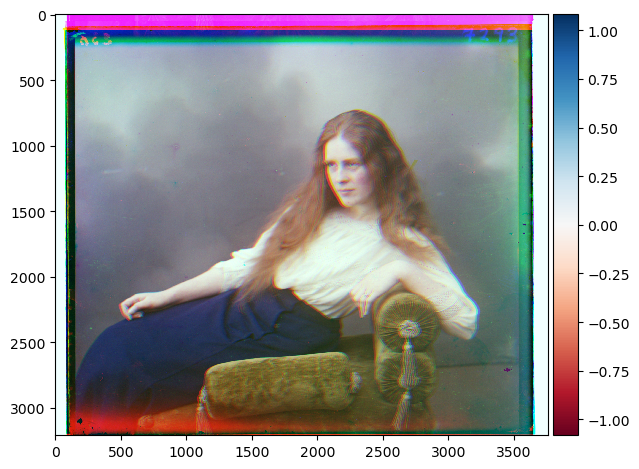

In [82]:
skio.imshow(aligned_blur_3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


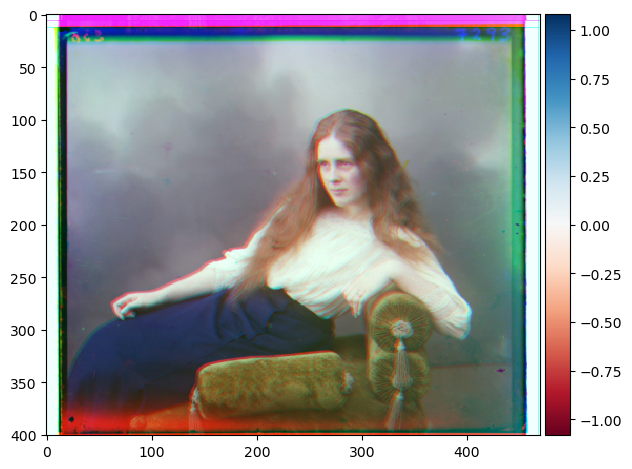

In [12]:

skio.imshow(aligned_blur_3)